In [ ]:
%pip install torch numpy pandas fastai

PADDY DISEASE CLASSIFICATION

In [1]:

from pathlib import Path
from fastai.vision.all import *

path = Path("/notebooks/paddy-disease-classification")
path.ls()

(#4) [Path('/notebooks/paddy-disease-classification/sample_submission.csv'),Path('/notebooks/paddy-disease-classification/test_images'),Path('/notebooks/paddy-disease-classification/train_images'),Path('/notebooks/paddy-disease-classification/train.csv')]

In [7]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


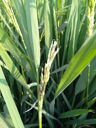

In [8]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [10]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f,files,n_workers=12)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

In [11]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(480,method='squish'),batch_tfms=aug_transforms(size=128,min_scale=0.75))

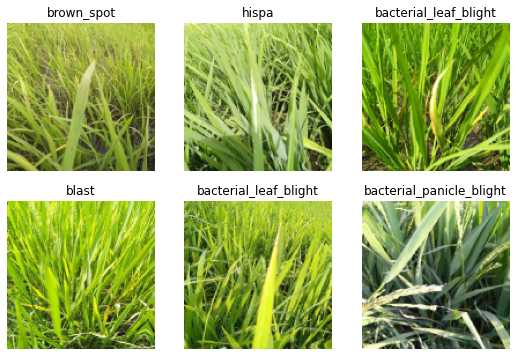

In [12]:
dls.show_batch(max_n=6)

In [15]:
%pip install --upgrade timm  huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 45.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.8.1
    Uninstalling huggingface-hub-0.8.1:
      Successfully uninstalled huggingface-hub-0.8.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from huggingface_hub import *
learn = vision_learner(dls, 'resnet26d',metrics=error_rate,path='.').to_fp16()

In [ ]:
learn.lr_find(suggest_funcs=(valley,slide))

In [ ]:
learn.fine_tune(3,0.01)

In [ ]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

In [ ]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [ ]:
probs,_,idxs= learn.get_preds(dl=tst_dl,with_decoded=True)
idxs

In [ ]:
dls.vocab

In [ ]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(),name="idxs").map(mapping)
results

In [ ]:
ss['label'] = results
ss

In [ ]:
ss.to_csv('submission.csv',index=False)

In [ ]:
iskaggle= False
if not iskaggle:
    from kaggle import api
    api.competition_submit('submission.csv','initial rn26d','paddy-disease-classification')

In [9]:
trn_path = Path('sml')

resize_images(path/'train_images'/'bacterial_panicle_blight', dest=trn_path,max_size=192,recurse=True)

In [6]:
dls= ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(256,method='squish'),batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [11]:
trn_path = path/'train_images'/'bacterial_panicle_blight'
def train(arch,item,batch,epochs = 5):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=item,batch_tfms=batch)
    learn = vision_learner(dls, arch,metrics=error_rate,path='.').to_fp16()
    learn.fine_tune(epochs,0.01)
    return learn

learn = train('resnet26d',Resize(192,method='squish'),aug_transforms(size=128,min_scale=0.75),3)

epoch,train_loss,valid_loss,error_rate,time
0,1.038728,2.643723,0.411765,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.804292,3.248263,0.582353,00:04
1,0.642639,0.694349,0.264706,00:04
2,0.471166,0.325401,0.141176,00:04


In [12]:
arch = 'convnext_small_in22k'

learn = train(arch,Resize(192),aug_transforms(size=128,min_scale=0.75))

/usr/local/lib/python3.9/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,0.841758,1.397707,0.317647,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.332619,0.163346,0.041176,00:12
1,0.226324,0.262609,0.064706,00:12
2,0.180954,0.177117,0.052941,00:12
3,0.148312,0.104364,0.023529,00:12
4,0.118652,0.110574,0.023529,00:12


In [14]:
def train(arch,size,item=Resize(480,method="squish"),accum=1,finetune= True,epochs = 12):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item,batch_tfms=aug_transforms(size=size,min_scale=0.75),bs=64//accum)
    cbs = GradientAccumulation(64) if accum  else []
    learn = vision_learner(dls, arch,metrics=error_rate,cbs=cbs).to_fp16()
    if(finetune):
        learn.fine_tune(epochs,0.01)
        return learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs,0.01)

learn = train('convnext_small_in22k',128,epochs=1,accum=1,finetune=False)

/usr/local/lib/python3.9/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,3.352338,62.781067,0.800000,00:13


In [16]:
res = 640,480
models ={
    "convnext_large_in22k": {
        (Resize(res),(320,244))
    },
    'vit_large_match16_224':{
        (Resize(480,method="squish"),224),
        (Resize(res),224)
    },
    'swinv2_large_window12_192_22k':{
        (Resize(480,method="squish"),192),
        (Resize(res),192)
    },
    'swin_large_patch4_window7_224':{
        (Resize((res),224))
    }
}


In [19]:
import gc 
trn_path = path/'train_images'

tta_res = []
for arch,details in models.items():
    for item,size in details:
        print('---',arch)
        print(size)
        print(item.name)
        tta_res.append(train(arch,size,item=item,accum=2))
        gc.collect()
        torch.cuda.empty_cache()
    
    

--- convnext_large_in22k
(320, 244)
Resize -- {'size': (480, 640), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}


/usr/local/lib/python3.9/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_large_in22k to current convnext_large.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,0.847618,0.557181,0.174451,16:45


epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 